**Observation about the data**

This is real world data that is slightly messy, which most YouTube video's don't even bother to look at, or just give it a cursory glance. That unsexy part of trying to fix data gets glossed over or outright ignored. Fun? No. Necessary? Yes.

To do due it justice won't fit nicely into a 1/2 hour YouTube video about EDA or datascience. So, I'll make an attempt to fix the most glaring issues. Real world dictates progress, not perfection. And nothing is ever perfect anyways. Models are just that. Models of reality, not reality itself.

In [1]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Scott\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
plt.style.use('ggplot')
pd.options.display.width = 0

from IPython.display import display
from PIL import Image

## Import Data

In [3]:
train = pd.read_excel('../Titanic_EDA/titanic/train_fix.xlsx')
test = pd.read_csv('../Titanic_EDA/titanic/test.csv')

In [4]:
train.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Boarding,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,A/5,21171,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,PC,17599,71.2833,C85,C
2,3,1,3,female,26.0,0,0,STON/O2.,3101282,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,NaN,113803,53.1000,C123,S
4,5,0,3,male,35.0,0,0,NaN,373450,8.0500,NaN,S
5,6,0,3,male,NaN,0,0,NaN,330877,8.4583,NaN,Q
6,7,0,1,male,54.0,0,0,NaN,17463,51.8625,E46,S
7,8,0,3,male,2.0,3,1,NaN,349909,21.0750,NaN,S
8,9,1,3,female,27.0,0,2,NaN,347742,11.1333,NaN,S
9,10,1,2,female,14.0,1,0,NaN,237736,30.0708,NaN,C


Some things are just more convenient to do on a spreadsheet. I removed the passenger names column. The *Ticket* column had what research shows as a ticket number along with Deck info and maybe a embarking/ boarding order number, so I separated that into two separate colulmns.

- Need to change *Sex* column from male/female to 1/0, and estimate missing ages.

In [5]:
train = pd.DataFrame(train)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       230 non-null    object 
 8   Boarding     886 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket         661
Boarding         5
Fare             0
Cabin          687
Embarked         2
dtype: int64

It looks like many ages are missing, and per the Data Description, "**age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5"**, so need to imput those rows, as there are far too many to delete, unlike Embarked, where only two are missing. My guess is that those individuals were very lucky to have missed the boat. As for *Cabin* hmm, might have to do some feature engineering or some sort to see if any possible loose correlations exist to be able to assign a cabin to all those NaN's.
- A lot of missing *Ticket* info and *Cabin* info that will need to be imputed.
- Not to certain the *Boarding* column will be of much use, but I'll keep it around just in case.

## Modifing DataFrame

In [8]:
# Convert 'Sex' column: 'male' -> 1, 'female' -> 0
train['Sex'] = train['Sex'].map({'male': 1, 'female': 0}).astype('int32')

In [9]:
train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Boarding,Fare,Cabin,Embarked
0,1,0,3,1,22.0,1,0,A/5,21171,7.2500,NaN,S
1,2,1,1,0,38.0,1,0,PC,17599,71.2833,C85,C
2,3,1,3,0,26.0,0,0,STON/O2.,3101282,7.9250,NaN,S
3,4,1,1,0,35.0,1,0,NaN,113803,53.1000,C123,S
4,5,0,3,1,35.0,0,0,NaN,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.0,0,0,NaN,211536,13.0000,NaN,S
887,888,1,1,0,19.0,0,0,NaN,112053,30.0000,B42,S
888,889,0,3,0,NaN,1,2,W./C.,6607,23.4500,NaN,S
889,890,1,1,1,26.0,0,0,NaN,111369,30.0000,C148,C


Added missing age's using sci-kit learn Linear Regression for Imputation. Using regular mean imputation is the lazy/bad way to input missing data. It can alter the data's kurtosis by reducing variability by increasing the 'peakedness' or flatten the tails.

In [10]:
#Features to use to computate missing age values.
features = ['Sex', 'Pclass', 'Parch', 'SibSp']

# Split the data into observed and missing Age.
train_obs = train[train['Age'].notnull()]
train_missing = train[train['Age'].isnull()]

# Fit the model on rows with observed Age.
X_train = train_obs[features]
y_train = train_obs['Age']
lr = LinearRegression().fit(X_train, y_train)

# Predict Age for missing entries.
X_missing = train_missing[features]
predicted_age = lr.predict(X_missing)

# add noise to reflect uncertainty.
sigma = np.std(y_train - lr.predict(X_train))
predicted_age_noisy = predicted_age + np.random.normal(0, sigma, size=predicted_age.shape)

# Impute the missing Age values.
train.loc[train['Age'].isnull(), 'Age'] = predicted_age_noisy

In [11]:
train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Boarding,Fare,Cabin,Embarked
0,1,0,3,1,22.000000,1,0,A/5,21171,7.2500,NaN,S
1,2,1,1,0,38.000000,1,0,PC,17599,71.2833,C85,C
2,3,1,3,0,26.000000,0,0,STON/O2.,3101282,7.9250,NaN,S
3,4,1,1,0,35.000000,1,0,NaN,113803,53.1000,C123,S
4,5,0,3,1,35.000000,0,0,NaN,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.000000,0,0,NaN,211536,13.0000,NaN,S
887,888,1,1,0,19.000000,0,0,NaN,112053,30.0000,B42,S
888,889,0,3,0,2.447186,1,2,W./C.,6607,23.4500,NaN,S
889,890,1,1,1,26.000000,0,0,NaN,111369,30.0000,C148,C


Here I decided to use Mode Imputation as I discovered that the first letter in *Cabin* refers to the deck, and making an assumption that those with the money had the ability to purchase a cabin, and those without, didn't.

In [12]:
# Extract the first letter of the Cabin column (deck identifier)
train['Deck'] = train['Cabin'].str[0]

# Impute missing Deck values with the most common Deck per Pclass
train['Deck'] = train.groupby('Pclass')['Deck'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'U'))


In [13]:
print(train[['Pclass', 'Deck']].head(10))  # Check first 10 rows

   Pclass Deck
0       3    F
1       1    C
2       3    F
3       1    C
4       3    F
5       3    F
6       1    E
7       3    F
8       3    F
9       2    F


In [14]:
#Added new Deck column
train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Boarding,Fare,Cabin,Embarked,Deck
0,1,0,3,1,22.000000,1,0,A/5,21171,7.2500,NaN,S,F
1,2,1,1,0,38.000000,1,0,PC,17599,71.2833,C85,C,C
2,3,1,3,0,26.000000,0,0,STON/O2.,3101282,7.9250,NaN,S,F
3,4,1,1,0,35.000000,1,0,NaN,113803,53.1000,C123,S,C
4,5,0,3,1,35.000000,0,0,NaN,373450,8.0500,NaN,S,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.000000,0,0,NaN,211536,13.0000,NaN,S,F
887,888,1,1,0,19.000000,0,0,NaN,112053,30.0000,B42,S,B
888,889,0,3,0,2.447186,1,2,W./C.,6607,23.4500,NaN,S,F
889,890,1,1,1,26.000000,0,0,NaN,111369,30.0000,C148,C,C


Now to change the *Deck* letter to number via one-hot-encoding. 

In [15]:
train_encoded = pd.get_dummies(train['Deck'], dtype=int)
train_encoded = train_encoded.rename(columns={'A': 'Deck-A', 'B': 'Deck-B',  'C': 'Deck-C', 'D': 'Deck-D', 'E': 'Deck-E', 'F': 'Deck-F',  'G': 'Deck-G', 'T': 'Deck-T'})
print('\n DataFrame after performing One-hot Encoding')
display(train_encoded)


 DataFrame after performing One-hot Encoding


,Deck-A,Deck-B,Deck-C,Deck-D,Deck-E,Deck-F,Deck-G,Deck-T
0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
886,0,0,0,0,0,1,0,0
887,0,1,0,0,0,0,0,0
888,0,0,0,0,0,1,0,0
889,0,0,1,0,0,0,0,0


Lets do the same for *Embarked* column

In [16]:
# Extract the first letter of the Embarked column
train['Embarked'] = train['Embarked'].str[0]

# Impute missing Embarked values with the most common per Pclass
train['Embarked'] = train.groupby('Pclass')['Embarked'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'U'))

In [17]:
print(train[['Pclass', 'Embarked']].head(10))

   Pclass Embarked
0       3        S
1       1        C
2       3        S
3       1        S
4       3        S
5       3        Q
6       1        S
7       3        S
8       3        S
9       2        C


In [18]:
train_embarked = pd.get_dummies(train['Embarked'], dtype=int)
train_embarked = train_embarked.rename(columns={'C': 'Embarked-C', 'Q': 'Embarked-Q',  'S': 'Embarked-S'})
print('\n DataFrame after performing One-hot Encoding')
display(train_embarked)


 DataFrame after performing One-hot Encoding


,Embarked-C,Embarked-Q,Embarked-S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
886,0,0,1
887,0,0,1
888,0,0,1
889,1,0,0


Add the new one-hot encoded *Deck* and *Embarked* back into the DataFrame

In [19]:
train_new = train.copy()
train_new[['Deck-A', 'Deck-B', 'Deck-C', 'Deck-D', 'Deck-E', 'Deck-F', 'Deck-G', 'Deck-T']] = train_encoded[['Deck-A', 'Deck-B', 'Deck-C', 'Deck-D', 'Deck-E', 'Deck-F', 'Deck-G', 'Deck-T']]
print(train_new)

     PassengerId  Survived  Pclass  Sex        Age  SibSp  Parch    Ticket  \
0              1         0       3    1  22.000000      1      0       A/5   
1              2         1       1    0  38.000000      1      0        PC   
2              3         1       3    0  26.000000      0      0  STON/O2.   
3              4         1       1    0  35.000000      1      0       NaN   
4              5         0       3    1  35.000000      0      0       NaN   
..           ...       ...     ...  ...        ...    ...    ...       ...   
886          887         0       2    1  27.000000      0      0       NaN   
887          888         1       1    0  19.000000      0      0       NaN   
888          889         0       3    0   2.447186      1      2     W./C.   
889          890         1       1    1  26.000000      0      0       NaN   
890          891         0       3    1  32.000000      0      0       NaN   

    Boarding     Fare  ... Embarked Deck Deck-A  Deck-B  Deck-C

In [20]:
train_emb = train_new.copy()
train_emb[['Embarked-C', 'Embarked-Q', 'Embarked-S']] = train_embarked[['Embarked-C', 'Embarked-Q', 'Embarked-S']]
print(train_emb)

     PassengerId  Survived  Pclass  Sex        Age  SibSp  Parch    Ticket  \
0              1         0       3    1  22.000000      1      0       A/5   
1              2         1       1    0  38.000000      1      0        PC   
2              3         1       3    0  26.000000      0      0  STON/O2.   
3              4         1       1    0  35.000000      1      0       NaN   
4              5         0       3    1  35.000000      0      0       NaN   
..           ...       ...     ...  ...        ...    ...    ...       ...   
886          887         0       2    1  27.000000      0      0       NaN   
887          888         1       1    0  19.000000      0      0       NaN   
888          889         0       3    0   2.447186      1      2     W./C.   
889          890         1       1    1  26.000000      0      0       NaN   
890          891         0       3    1  32.000000      0      0       NaN   

    Boarding     Fare  ... Deck-B Deck-C Deck-D  Deck-E  Deck-F

In [21]:
train_combined = pd.concat([train_embarked[['Embarked-C', 'Embarked-Q', 'Embarked-S']], 
                            train_encoded[['Deck-A', 'Deck-B', 'Deck-C', 'Deck-D', 'Deck-E', 'Deck-F', 'Deck-G', 'Deck-T']]], 
                           axis=1)


In [22]:
train_combined

,Embarked-C,Embarked-Q,Embarked-S,Deck-A,Deck-B,Deck-C,Deck-D,Deck-E,Deck-F,Deck-G,Deck-T
0,0,0,1,0,0,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0,0,1,0,0
3,0,0,1,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,1,0,0,0,0,0,1,0,0
887,0,0,1,0,1,0,0,0,0,0,0
888,0,0,1,0,0,0,0,0,1,0,0
889,1,0,0,0,0,1,0,0,0,0,0


In [23]:
train_final = pd.concat([train, train_combined], axis=1)
train_final

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Boarding,Fare,...,Embarked-Q,Embarked-S,Deck-A,Deck-B,Deck-C,Deck-D,Deck-E,Deck-F,Deck-G,Deck-T
0,1,0,3,1,22.000000,1,0,A/5,21171,7.2500,...,0,1,0,0,0,0,0,1,0,0
1,2,1,1,0,38.000000,1,0,PC,17599,71.2833,...,0,0,0,0,1,0,0,0,0,0
2,3,1,3,0,26.000000,0,0,STON/O2.,3101282,7.9250,...,0,1,0,0,0,0,0,1,0,0
3,4,1,1,0,35.000000,1,0,NaN,113803,53.1000,...,0,1,0,0,1,0,0,0,0,0
4,5,0,3,1,35.000000,0,0,NaN,373450,8.0500,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.000000,0,0,NaN,211536,13.0000,...,0,1,0,0,0,0,0,1,0,0
887,888,1,1,0,19.000000,0,0,NaN,112053,30.0000,...,0,1,0,1,0,0,0,0,0,0
888,889,0,3,0,2.447186,1,2,W./C.,6607,23.4500,...,0,1,0,0,0,0,0,1,0,0
889,890,1,1,1,26.000000,0,0,NaN,111369,30.0000,...,0,0,0,0,1,0,0,0,0,0


*Ticket* column has so many missing values now since extracting the boarding/embarkation numbers to a new column and have Embarked and Deck columns with both categorical and one-hot encoded columns, imo there isn't much value left in the Ticket column.

*Boarding* column is a string so I'll convert it to an int, there's also one row that has the word 'Basle' in it for some reason so I'll fix that too.

In [24]:
print(train_final.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Sex              int32
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Boarding        object
Fare           float64
Cabin           object
Embarked        object
Deck            object
Embarked-C       int64
Embarked-Q       int64
Embarked-S       int64
Deck-A           int64
Deck-B           int64
Deck-C           int64
Deck-D           int64
Deck-E           int64
Deck-F           int64
Deck-G           int64
Deck-T           int64
dtype: object


In [25]:
train_final['Boarding'] = train_final['Boarding'].fillna(0)


In [26]:
train_final['Boarding'] = train_final['Boarding'].replace('Basle', 0)

C:\Users\Scott\AppData\Local\Temp\ipykernel_5240\1955954813.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_final['Boarding'] = train_final['Boarding'].replace('Basle', 0)


In [27]:
train_final['Boarding'] = train_final['Boarding'].astype(int)

In [28]:
print(train_final.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Sex              int32
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Boarding         int64
Fare           float64
Cabin           object
Embarked        object
Deck            object
Embarked-C       int64
Embarked-Q       int64
Embarked-S       int64
Deck-A           int64
Deck-B           int64
Deck-C           int64
Deck-D           int64
Deck-E           int64
Deck-F           int64
Deck-G           int64
Deck-T           int64
dtype: object


In [29]:
train_final.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Boarding', 'Fare', 'Cabin', 'Embarked', 'Deck', 'Embarked-C',
       'Embarked-Q', 'Embarked-S', 'Deck-A', 'Deck-B', 'Deck-C', 'Deck-D',
       'Deck-E', 'Deck-F', 'Deck-G', 'Deck-T'],
      dtype='object')

In [30]:
train_scaled = train_final[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Boarding', 'Fare', 'Embarked-C', 'Embarked-Q', 'Embarked-S', 'Deck-A', 'Deck-B', 'Deck-C', 'Deck-D',
       'Deck-E', 'Deck-F', 'Deck-G', 'Deck-T']].copy()
       

In [31]:
# Survival by age, binned
age_bins = [0, 12, 18, 30, 40, 50, 60, 100]
age_labels = ['0-12', '13-18', '19-30', '31-40', '41-50', '51-60', '60+']
train_scaled['Age_group'] = pd.cut(train_scaled['Age'], bins=age_bins, labels=age_labels)

age_survival_percentages = train_scaled.groupby('Age_group')['Survived'].mean() * 100

print("\nSurvival percentages by Age:")
print(age_survival_percentages)


Survival percentages by Age:
Age_group
0-12     51.111111
13-18    42.500000
19-30    34.461538
31-40    41.463415
41-50    34.513274
51-60    40.000000
60+      22.727273
Name: Survived, dtype: float64


C:\Users\Scott\AppData\Local\Temp\ipykernel_5240\1624456531.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_survival_percentages = train_scaled.groupby('Age_group')['Survived'].mean() * 100


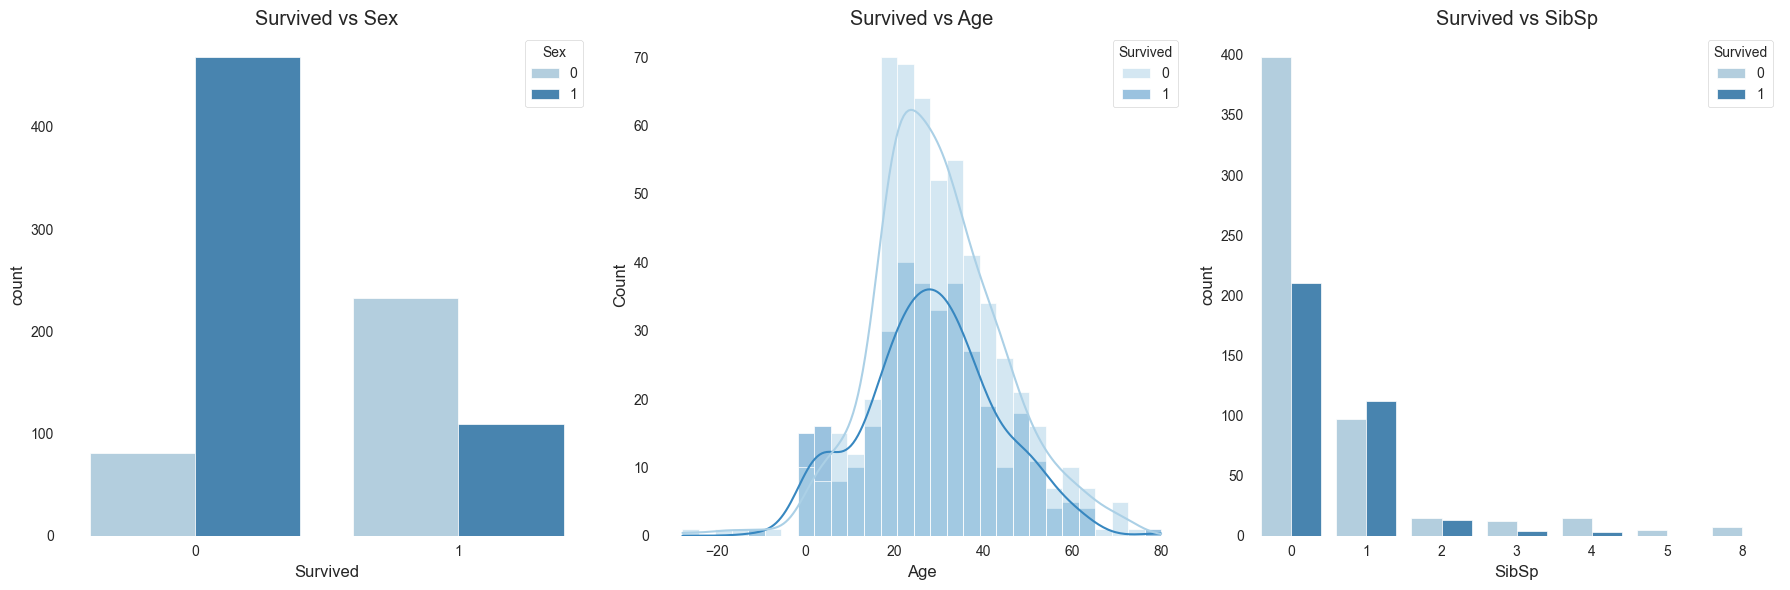

In [32]:
sns.set_style("white")

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Survived vs Sex
sns.countplot(x='Survived', hue='Sex', data=train_final, palette='Blues', ax=axes[0])
axes[0].set_title('Survived vs Sex')

# Plot 2: Survived vs Age
sns.histplot(data=train_final, x='Age', hue='Survived', kde=True, palette='Blues', ax=axes[1])
axes[1].set_title('Survived vs Age')

# Plot 3: Survived vs SibSp
sns.countplot(x='SibSp', data=train_final, hue='Survived', palette='Blues', ax=axes[2])
axes[2].set_title('Survived vs SibSp')


# Apply bg removal & remove borders
for ax in axes:
    ax.set_frame_on(False)  # Remove entire frame
    for spine in ax.spines.values():  # Ensure spines are removed
        spine.set_visible(False)

plt.tight_layout()

plt.show()

Female = 1 <br/>
Male = 0 <br/>
Survived = 1 <br/>

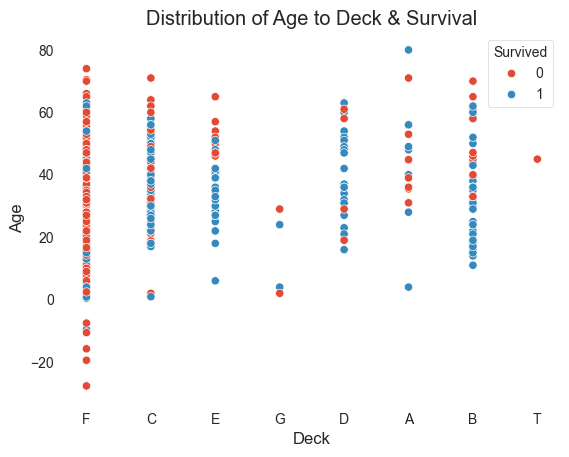

In [33]:
sns.scatterplot(data=train_final, x='Deck', y='Age', hue='Survived')
plt.title('Distribution of Age to Deck & Survival')

# Set bg to white
plt.gca().set_facecolor('white')
# Remove borders around plot
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()

Regardless of age, those on Deck F had the odds stacked against them.

Boxplot of ages per *Pclass*

C:\Users\Scott\AppData\Local\Temp\ipykernel_5240\1289004124.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_final, x='Pclass', y='Age', palette='Blues')


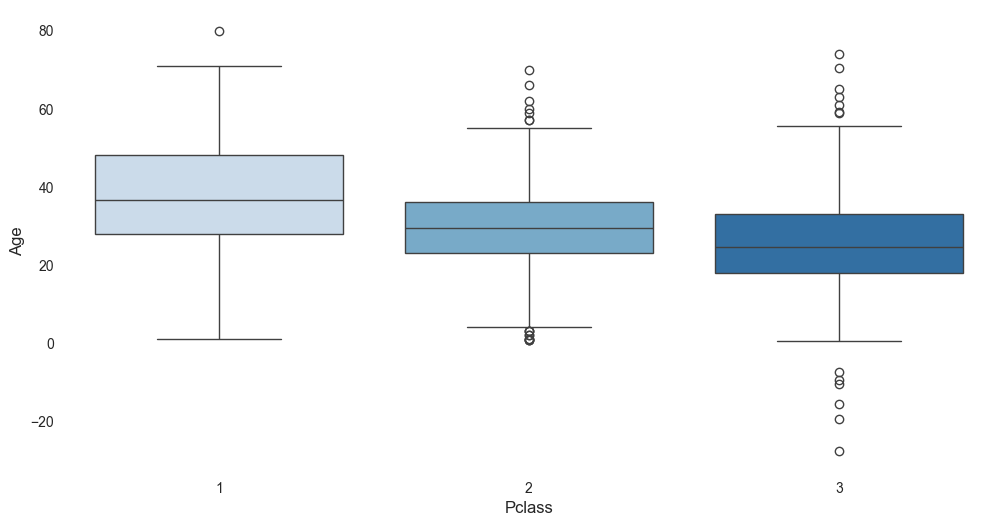

In [34]:
plt.figure(figsize=(12,6))
sns.boxplot(data=train_final, x='Pclass', y='Age', palette='Blues')

# Set bg to white
plt.gca().set_facecolor('white')
# Remove borders around plot
for spine in plt.gca().spines.values():
    spine.set_visible(False)

Show Survival percentages of each *Pclass* for each **Embarkation** and **Deck**

Here's a visual of Titanic's deck layout

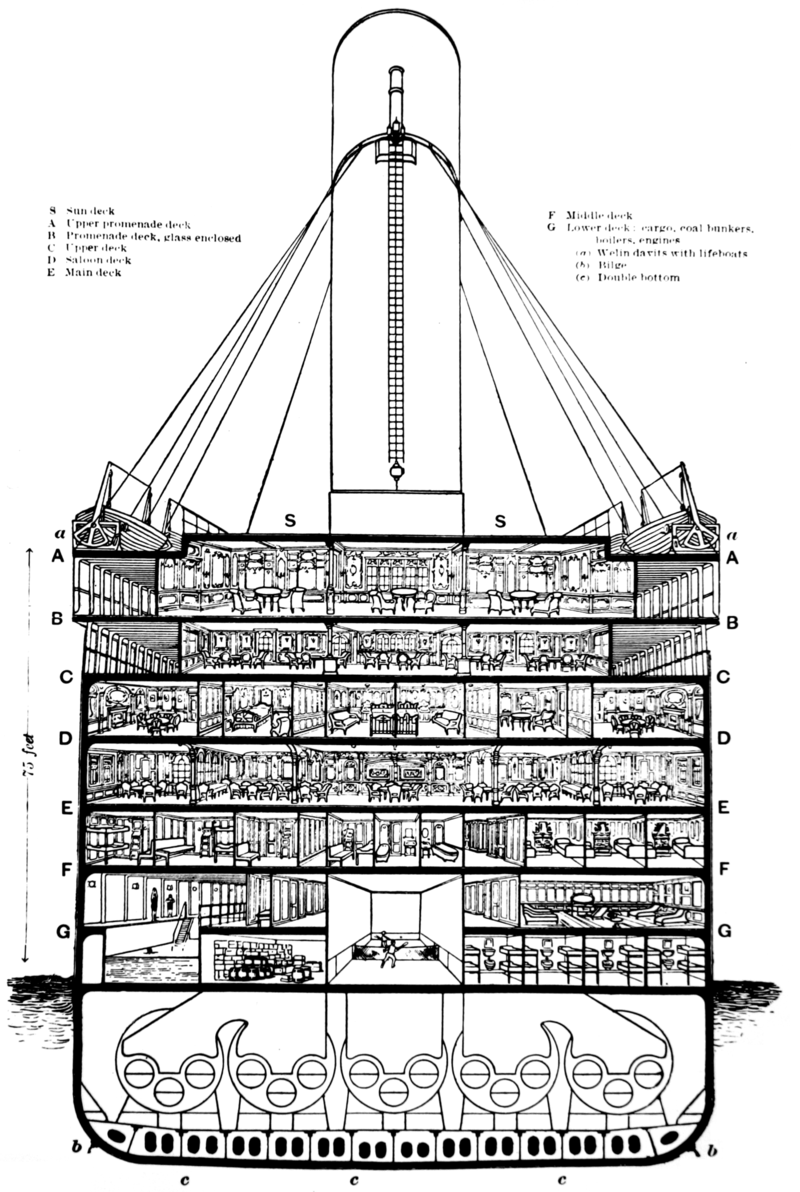

In [35]:
img = Image.open("./titanic/Titanic_cutaway_diagram.png")
display(img)

**Embarkation** Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

Passenger count per Embark location broken out by Passenger Class

In [36]:
# Melt the columns related to Embarked for long format
melted_df = train_final.melt(id_vars=['Pclass'], value_vars=['Embarked-C', 'Embarked-Q', 'Embarked-S'], var_name='Embarked', value_name='Boarded')

# Filter out rows where the passenger didn't board at Embarked location (where Boarded = 0)
melted_df = melted_df[melted_df['Boarded'] == 1]

# Group by 'Pclass' and 'Embarked' to get passenger count at each location
passenger_counts = melted_df.groupby(['Pclass', 'Embarked']).size().reset_index(name='Passenger Count')

# Pivot table
passenger_counts_pivot = passenger_counts.pivot(index='Embarked', columns='Pclass', values='Passenger Count').fillna(0)

print(passenger_counts_pivot)

Pclass        1    2    3
Embarked                 
Embarked-C   85   17   66
Embarked-Q    2    3   72
Embarked-S  129  164  353


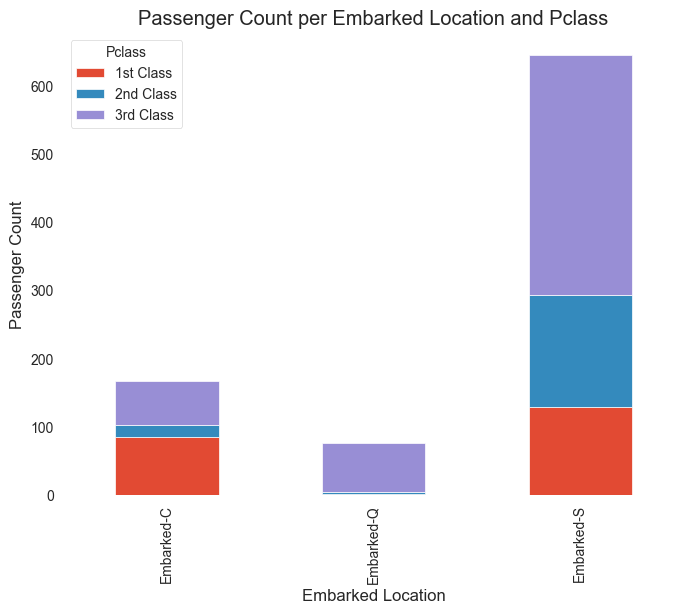

In [37]:
passenger_counts_pivot.plot(kind='bar', stacked=True, figsize=(8, 6))
sns.set_palette("coolwarm")

plt.title('Passenger Count per Embarked Location and Pclass')
plt.xlabel('Embarked Location')
plt.ylabel('Passenger Count')

plt.legend(title='Pclass', labels=['1st Class', '2nd Class', '3rd Class'])
# Set bg to white
plt.gca().set_facecolor('white')
# Remove borders around plot
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.show()

In [38]:
# Convert one-hot encoding of 'Embarked' and 'Deck' back to categorical labels
train_scaled['Embarked'] = train_scaled[['Embarked-C', 'Embarked-Q', 'Embarked-S']].idxmax(axis=1).str.replace('Embarked-', '')
train_scaled['Deck'] = train_scaled[['Deck-A', 'Deck-B', 'Deck-C', 'Deck-D', 'Deck-E', 'Deck-F', 'Deck-G', 'Deck-T']].idxmax(axis=1).str.replace('Deck-', '')

# Survival percentages by Pclass and Embarked
embarked_survival_percentages = train_scaled.groupby(['Pclass', 'Embarked'])['Survived'].mean() * 100

# Survival percentages by Pclass and Deck
deck_survival_percentages = train_scaled.groupby(['Pclass', 'Deck'])['Survived'].mean() * 100

print("Survival percentages by Pclass and Embarked:\n", embarked_survival_percentages)
print("\nSurvival percentages by Pclass and Deck:\n", deck_survival_percentages)

Survival percentages by Pclass and Embarked:
 Pclass  Embarked
1       C           69.411765
        Q           50.000000
        S           58.914729
2       C           52.941176
        Q           66.666667
        S           46.341463
3       C           37.878788
        Q           37.500000
        S           18.980170
Name: Survived, dtype: float64

Survival percentages by Pclass and Deck:
 Pclass  Deck
1       A        46.666667
        B        74.468085
        C        54.545455
        D        75.862069
        E        72.000000
        T         0.000000
2       D        75.000000
        E        75.000000
        F        46.022727
3       E       100.000000
        F        23.553719
        G        50.000000
Name: Survived, dtype: float64


Plot of the above

In [39]:
# Function to add percentage labels correctly
def add_percentages(ax, survival_dict, hue_col):
    for p in ax.patches:
        pclass = int(p.get_x() + 1)  # Extract Pclass from bar position
        
        # Get the hue category (Embarked or Deck) from the bar's color grouping
        hue_label = p.get_label()
        
        try:
            # Find the correct survival percentage for this Pclass and hue category
            value = survival_dict.loc[pclass, hue_label]
            
            # Annotate only if a valid percentage is found
            ax.annotate(f'{value:.1f}%', 
                        (p.get_x() + p.get_width() / 2, p.get_height()), 
                        ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')
        
        except KeyError:
            # If there's no matching value, skip this bar
            continue


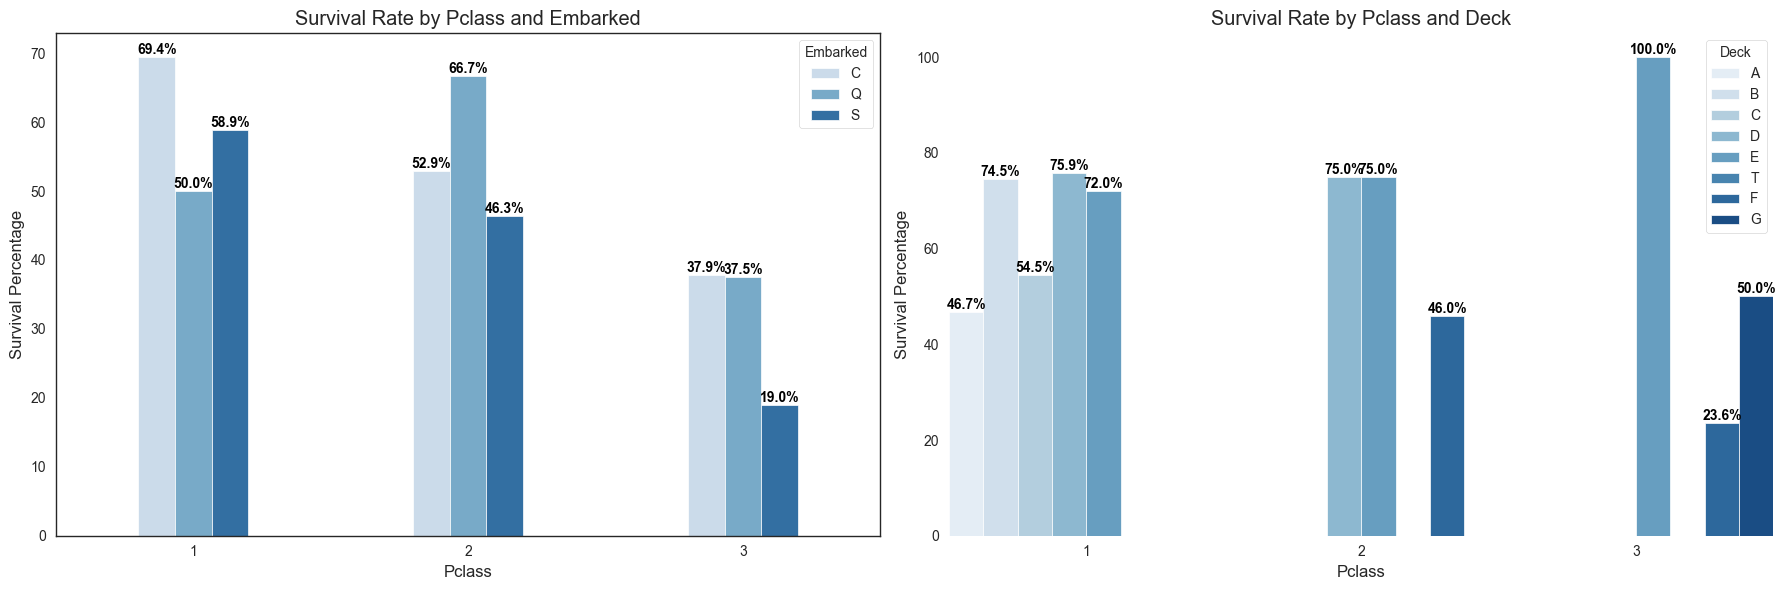

In [40]:
# Convert Series to DataFrame
df_embarked = embarked_survival_percentages.reset_index()
df_deck = deck_survival_percentages.reset_index()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Survival % by Pclass and Embarked
sns.barplot(x='Pclass', y='Survived', hue='Embarked', data=df_embarked, palette='Blues', ax=axes[0], width=0.4)
axes[0].set_title("Survival Rate by Pclass and Embarked")
axes[0].set_ylabel("Survival Percentage")
axes[0].set_xlabel("Pclass")
axes[0].legend(title="Embarked")

# Set background to white
plt.gca().set_facecolor('white')
# Remove the borders around the plot
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Add percentage labels
for p in axes[0].patches:
    height = p.get_height()
    if height > 0:
        axes[0].annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, height), 
                         ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

# Plot 2: Survival % by Pclass and Deck
sns.barplot(x='Pclass', y='Survived', hue='Deck', data=df_deck, palette='Blues', ax=axes[1], width=1.0)
axes[1].set_title("Survival Rate by Pclass and Deck")
axes[1].set_ylabel("Survival Percentage")
axes[1].set_xlabel("Pclass")
axes[1].legend(title="Deck")

# Add percentage labels
for p in axes[1].patches:
    height = p.get_height()
    if height > 0:
        axes[1].annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, height), 
                         ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

# Set bg to white
plt.gca().set_facecolor('white')
# Remove borders around plot
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.tight_layout()
plt.show()

Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

As one might expect, 1st class passengers had an overall higher percentage of survival compared to 2nd and 3rd class passengers. Interesting that 100% of those 3rd class passengers on Deck E survived. 

In [41]:
num_3rd_class_deck_E = train_scaled[(train_scaled['Pclass'] == 3) & (train_scaled['Deck-E'] == 1)].shape[0] # Counts matching rows
print(f"Number of 3rd class passengers on Deck E: {num_3rd_class_deck_E}")

Number of 3rd class passengers on Deck E: 3


Survival Rate by Deck and Embarkation Port

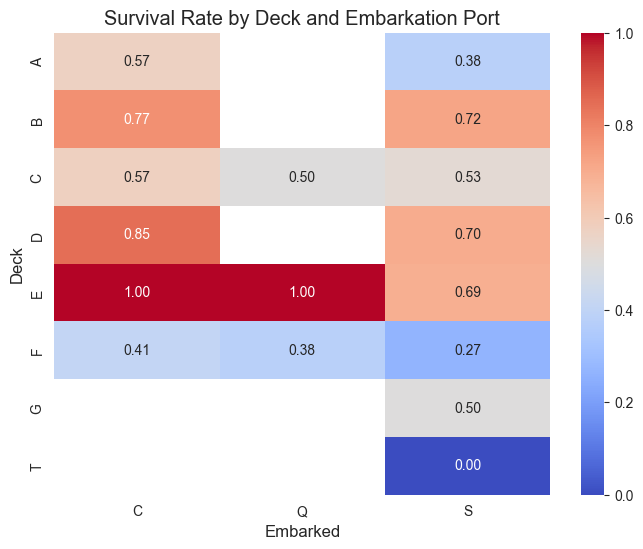

In [42]:
#pivot table for heatmap
deck_embarked_survival = train_scaled.groupby(['Deck', 'Embarked'])['Survived'].mean().unstack()

plt.figure(figsize=(8, 6))
sns.heatmap(deck_embarked_survival, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Survival Rate by Deck and Embarkation Port")

# Set bg to white
plt.gca().set_facecolor('white')
# Remove border around plot
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()

Being in the 1st class, and female had a definite advantage! Even 3rd class female's fared better than 1st class males.

In [43]:
train_corr = train_final[['Embarked-C', 'Embarked-Q', 'Embarked-S', 'SibSp', 'Parch', 'Deck-A', 'Deck-B', 'Deck-C', 'Deck-D', 'Deck-E', 'Deck-F', 'Deck-G', 'Deck-T']].corr()

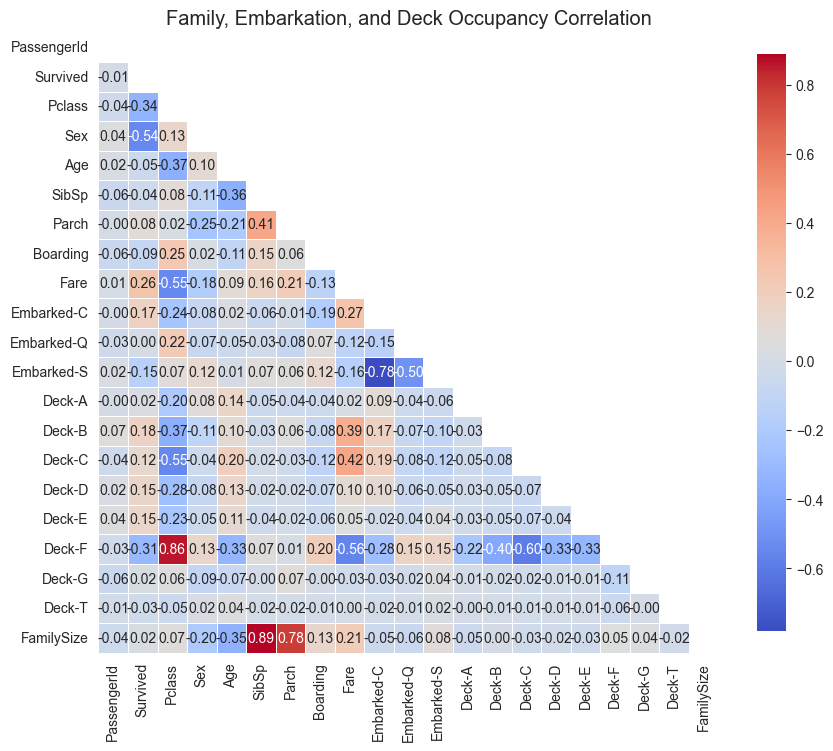

In [ ]:
# Select only numeric columns for correlation calculation
train_corr = train_final.select_dtypes(include=['number']).corr()

# Mask for the upper triangle
mask = np.triu(np.ones_like(train_corr, dtype=bool))

fig, ax = plt.subplots(figsize=(10, 10))

# Create heatmap
sns.heatmap(train_corr, annot=True, mask=mask, cmap='coolwarm', fmt=".2f", 
            linewidths=0.5, square=True, cbar_kws={"shrink": 0.75})

plt.title('Family, Embarkation, and Deck Occupancy Correlation')

plt.show()

At the time of the Titanic's maiden voyage, both Queenstown (now Cobh) and Southampton were considered less affluent, so there's a slight correlation to Deck-F having more occupants from those two cities vs. Cherbug, France. With a higher correlation of Cheburg residents occupying Decks A, B, and C.

It appears that "C" or Cherbourg had better overall survival rates and higher decks. <br/>
Research states that all but two lifeboats were located on the boat deck, the highest deck on the ship. Odd that E deck passengers had an extremely high surival rate given that they were located in the middle deck.

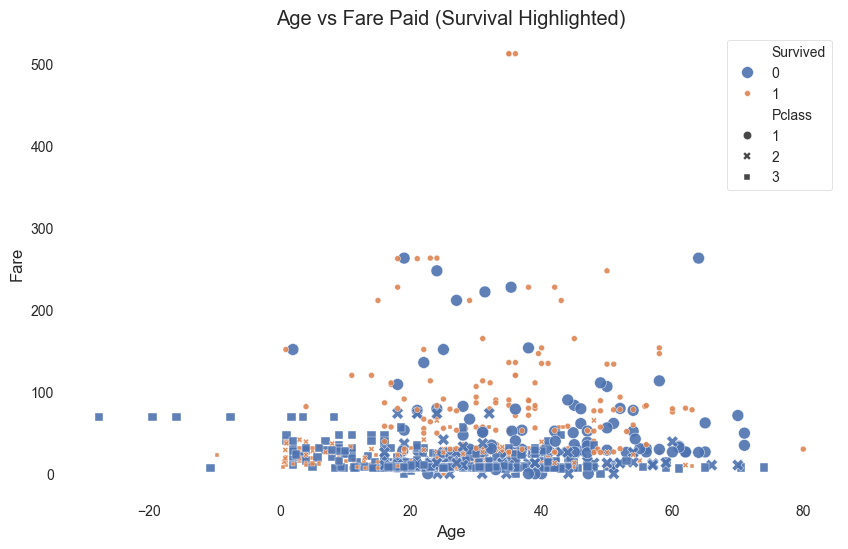

In [45]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Fare', hue='Survived', style='Pclass', data=train_final, palette='deep', hue_norm=(0, 7), size='Survived', alpha=0.9)
plt.title("Age vs Fare Paid (Survival Highlighted)")

# Set bg to white
plt.gca().set_facecolor('white')
# Remove borders around plot
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()

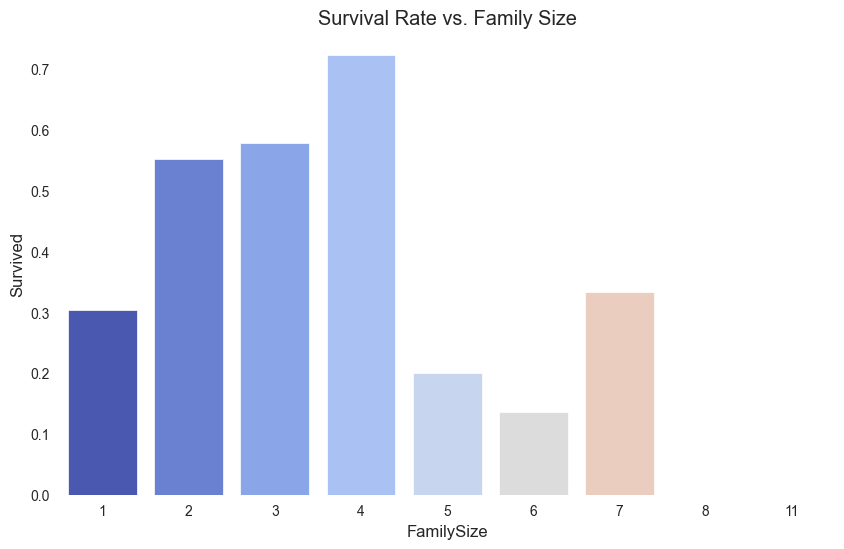

In [46]:
train_final['FamilySize'] = train_final['SibSp'] + train_final['Parch'] + 1

plt.figure(figsize=(10, 6))
sns.barplot(x='FamilySize', y='Survived', data=train_final, hue='FamilySize', legend=False, palette='coolwarm', errorbar=None)
plt.title("Survival Rate vs. Family Size")

# Set bg to white
plt.gca().set_facecolor('white')
# Remove borders around plot
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()

Interesting that family survival rates dropped dramatically for those with 5 or 6, but increased for a family size of 7. Maybe there were enough older children to help with the younger ones?

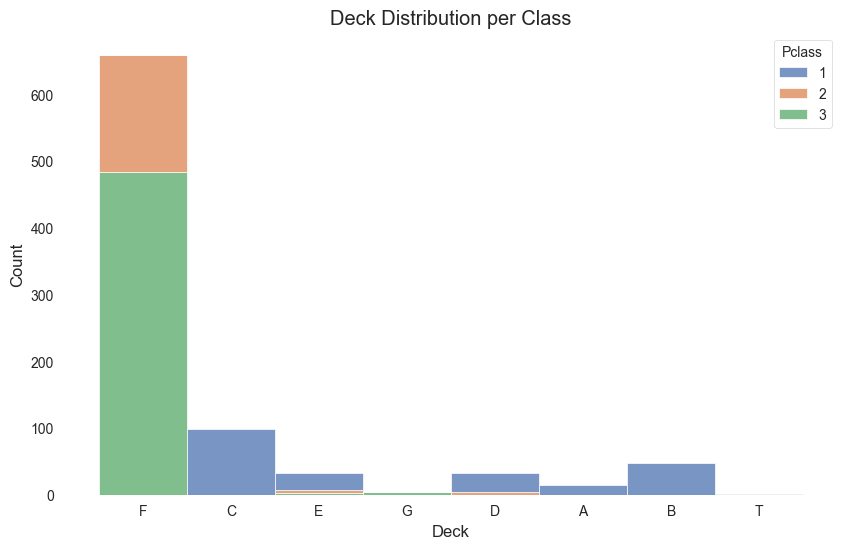

In [47]:
plt.figure(figsize=(10, 6))
sns.histplot(data=train_final, x='Deck', hue='Pclass', multiple="stack", palette='deep')
plt.title("Deck Distribution per Class")

# Set bg to white
plt.gca().set_facecolor('white')
# Remove borders around plot
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()

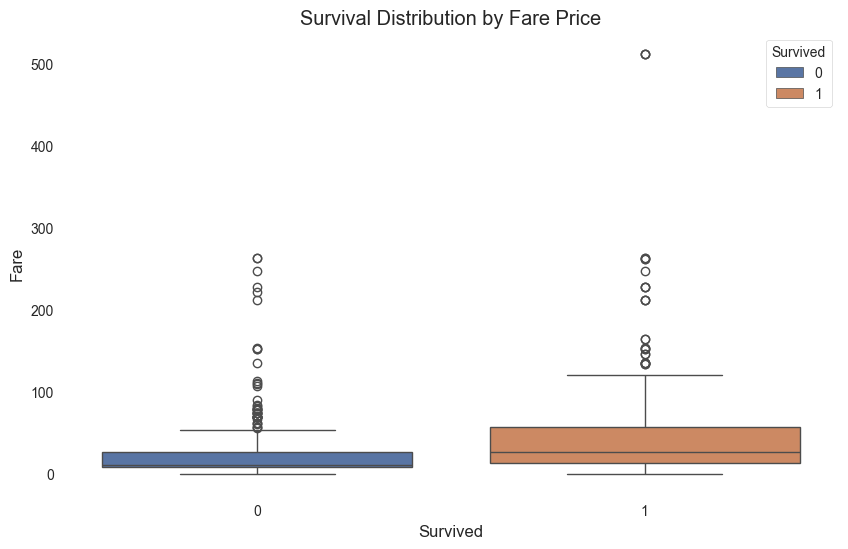

In [48]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Survived', y='Fare', data=train_final, hue='Survived', palette='deep')
plt.title("Survival Distribution by Fare Price")

# Set bg to white
plt.gca().set_facecolor('white')
# Remove borders around plot
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()

Looks like ticket price didn't matter somewhat for survival, but numerous outliers also paid a pretty penny yet didn't survive.

Ok, the real question. Women and children first, what's the verdict?

In [49]:
age_bins = [0, 12, 18, 60, 100]
age_labels = ["Child (0-12)", "Teen (13-18)", "Adult (19-59)", "Senior (60+)"]

# Create a new column for Age Groups
train_final["AgeGroup"] = pd.cut(train_final["Age"], bins=age_bins, labels=age_labels)

# Separate by Sex
male_data = train_final[train_final["Sex"] == 1]
female_data = train_final[train_final["Sex"] == 0]

# Calculate survival rates for each group
male_survival = male_data.groupby("AgeGroup")["Survived"].mean() * 100
female_survival = female_data.groupby("AgeGroup")["Survived"].mean() * 100

# Combine into a df for easier visualization
survival_rates = pd.DataFrame({
    "Male Survival (%)": male_survival,
    "Female Survival (%)": female_survival
})

print(survival_rates)

               Male Survival (%)  Female Survival (%)
AgeGroup                                             
Child (0-12)           45.833333            57.142857
Teen (13-18)            7.500000            77.500000
Adult (19-59)          17.381974            77.092511
Senior (60+)           10.526316           100.000000


C:\Users\Scott\AppData\Local\Temp\ipykernel_5240\1344049815.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  male_survival = male_data.groupby("AgeGroup")["Survived"].mean() * 100
C:\Users\Scott\AppData\Local\Temp\ipykernel_5240\1344049815.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  female_survival = female_data.groupby("AgeGroup")["Survived"].mean() * 100


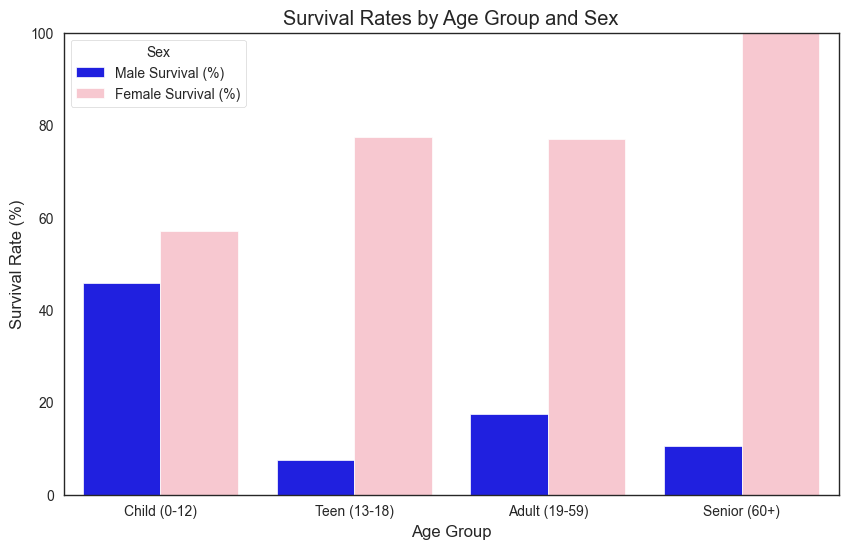

In [50]:
survival_rates = survival_rates.reset_index()

# Melt dataframe for seaborn compatibility
survival_melted = survival_rates.melt(id_vars="AgeGroup", var_name="Sex", value_name="Survival Rate (%)")

# Set up the figure
plt.figure(figsize=(10, 6))
sns.barplot(x="AgeGroup", y="Survival Rate (%)", hue="Sex", data=survival_melted, palette=["blue", "pink"])

plt.title("Survival Rates by Age Group and Sex")
plt.xlabel("Age Group")
plt.ylabel("Survival Rate (%)")
plt.ylim(0, 100)

plt.show()

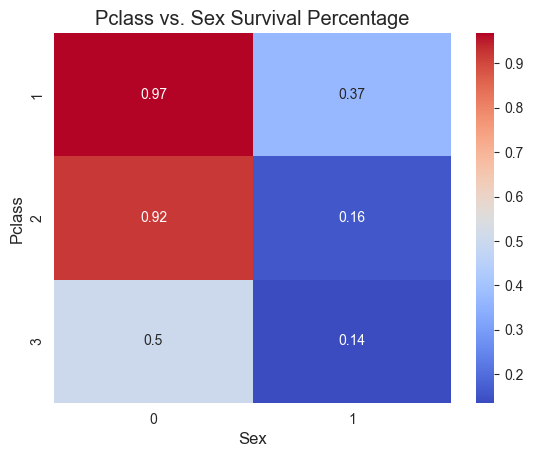

In [51]:
pivot = train_final.pivot_table(values="Survived", index="Pclass", columns="Sex")
sns.heatmap(pivot, annot=True, cmap="coolwarm")
plt.title("Pclass vs. Sex Survival Percentage")
plt.show()

First class females had a distinct advantage! Third class females fared better than first class males.

## State of the situation

Each feature will get a weight reflecting its survival impact.

|**Feature**|	**Possible Impact**|	**Weighting Approach**|
|-----------|----------------------|--------------------------|
|Pclass|	1st class had highest survival rates|	Higher class gets higher points
|Sex|	Females survived more|	0 for male, 1 for female
|AgeGroup|	Children had priority|	Assign decreasing points as age increases
|Fare|	Higher fares correlated with higher survival|	Normalize and assign points
|Deck|	Upper decks had easier access to lifeboats|	Rank decks and assign values
|SibSp & Parch|	More family could be good or bad|	Experiment with weighting

A non-ML approach

In [52]:
# Copy dataframe to avoid modifying the original
train_final_copy = train_final.copy()

# Normalize
scaler = MinMaxScaler()
train_final_copy["Fare_Scaled"] = scaler.fit_transform(train_final_copy[["Fare"]])

# Encode Sex (Female = 1, Male = 0)
train_final_copy["Sex_Encoded"] = train_final_copy["Sex"]

# Assign Weights to Age Groups
age_weights = {"Child": 1.0, "Teen": 0.75, "Adult": 0.5, "Senior": 0.25}
train_final_copy["Age_Score"] = train_final_copy["AgeGroup"].map(age_weights)

# Fill missing AgeGroup values with 'Adult' (since it's the most common)
train_final_copy["AgeGroup"] = train_final_copy["AgeGroup"].astype(str).fillna("Adult")

#Map AgeGroup to numerical scores
age_weights = {"Child": 1.0, "Teen": 0.75, "Adult": 0.5, "Senior": 0.25}
train_final_copy["Age_Score"] = train_final_copy["AgeGroup"].map(age_weights)

# If NaNs remain
train_final_copy["Age_Score"].fillna(0.5, inplace=True)

# Assign Weights to Pclass (Higher class = Higher priority)
pclass_weights = {1: 1.0, 2: 0.5, 3: 0.25}
train_final_copy["Pclass_Score"] = train_final_copy["Pclass"].map(pclass_weights)

# Assign Weights to Deck (Higher decks had higher survival rates)
deck_weights = {"A": 1.0, "B": 0.9, "C": 0.8, "D": 0.7, "E": 0.6, "F": 0.5, "G": 0.4, "T": 0.3}
train_final_copy["Deck_Score"] = train_final_copy["Deck"].map(deck_weights)

# Family Size Impact (SibSp + Parch)
train_final_copy["Family_Size"] = train_final_copy["SibSp"] + train_final_copy["Parch"]
train_final_copy["Family_Score"] = 1 / (1 + train_final_copy["Family_Size"])  # Smaller families get higher priority

train_final_copy["Survival_Score"] = (
    (train_final_copy["Sex_Encoded"] * 1.5) +   
    (train_final_copy["Age_Score"] * 1.2) +     
    (train_final_copy["Pclass_Score"] * 1.3) +  
    (train_final_copy["Fare_Scaled"] * 0.8) +   
    (train_final_copy["Deck_Score"] * 1.1) +    
    (train_final_copy["Family_Score"] * 0.7)    
)

# Display top passengers by Survival Score
train_final_copy[["Survival_Score", "Survived", "Sex", "Pclass", "AgeGroup", "Fare", "Deck"]].round(1).sort_values(by="Survival_Score", ascending=False).head(10)

C:\Users\Scott\AppData\Local\Temp\ipykernel_5240\2892698568.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_final_copy["Age_Score"].fillna(0.5, inplace=True)


,Survival_Score,Survived,Sex,Pclass,AgeGroup,Fare,Deck
737,5.9,1,1,1,Adult (19-59),512.3,B
679,5.5,1,1,1,Adult (19-59),512.3,B
96,5.3,0,1,1,Senior (60+),34.7,A
557,5.3,0,1,1,Adult (19-59),227.5,C
527,5.3,0,1,1,Adult (19-59),221.8,C
867,5.3,0,1,1,Adult (19-59),50.5,A
185,5.3,0,1,1,Adult (19-59),50.0,A
583,5.3,0,1,1,Adult (19-59),40.1,A
647,5.3,1,1,1,Adult (19-59),35.5,A
475,5.3,0,1,1,Adult (19-59),52.0,A


These scores are highly subjective with weights assigned with no objective measure whatsoever. Just what I thought seemed resonable.

C:\Users\Scott\AppData\Local\Temp\ipykernel_5240\4150134832.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Pclass", y="Survival_Score", data=train_final_copy, palette="Blues")


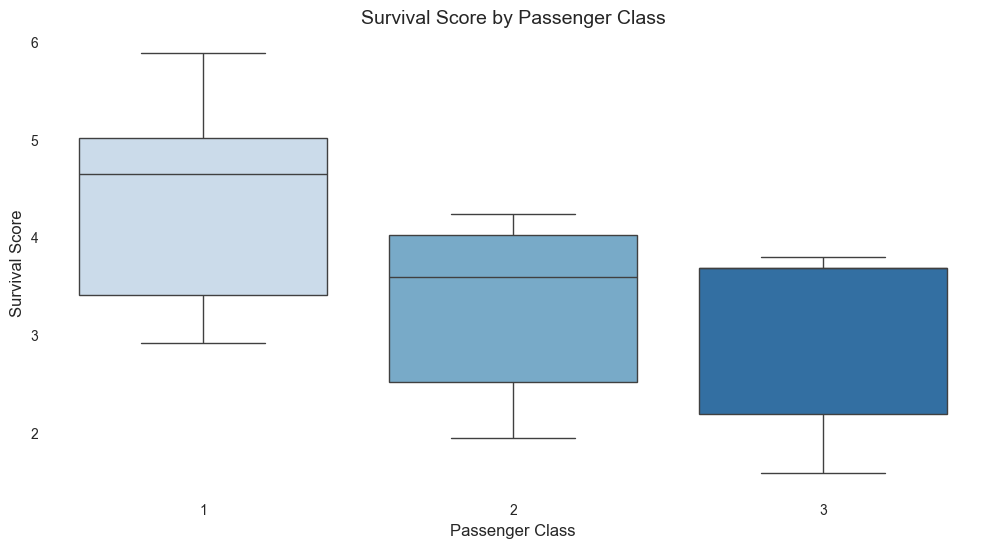

In [53]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Pclass", y="Survival_Score", data=train_final_copy, palette="Blues")
plt.title("Survival Score by Passenger Class", fontsize=14)
plt.xlabel("Passenger Class", fontsize=12)
plt.ylabel("Survival Score", fontsize=12)

# Set bg to white
plt.gca().set_facecolor('white')
# Remove borders around plot
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()

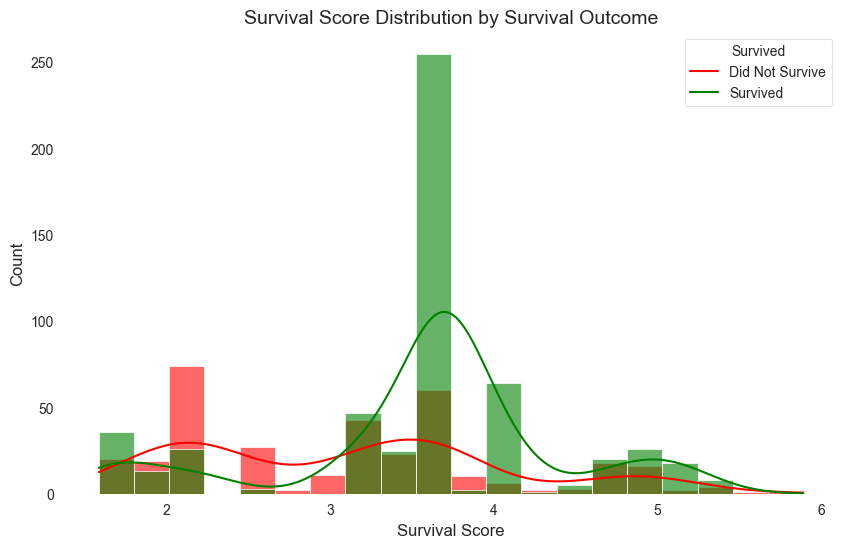

In [54]:
plt.figure(figsize=(10, 6))
sns.histplot(data=train_final_copy, x="Survival_Score", hue="Survived", bins=20, kde=True, palette=["green", "red"], alpha=0.6)
plt.title("Survival Score Distribution by Survival Outcome", fontsize=14)
plt.xlabel("Survival Score", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Survived", labels=["Did Not Survive", "Survived"])

# Set bg to white
plt.gca().set_facecolor('white')
# Remove borders around plot
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()

### Train a Random Forest Classifier and plot the feature importances.

C:\Users\Scott\AppData\Local\Temp\ipykernel_5240\582392664.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='Blues_r')


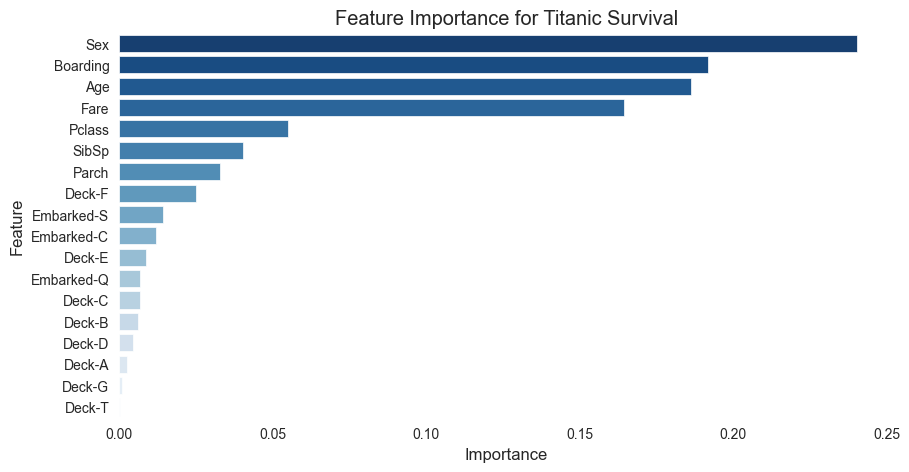

Random Forest Accuracy: 0.81


In [55]:
#Relevant features
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
        'Boarding', 'Fare', 'Embarked-C',
       'Embarked-Q', 'Embarked-S', 'Deck-A', 'Deck-B', 'Deck-C', 'Deck-D',
       'Deck-E', 'Deck-F', 'Deck-G', 'Deck-T']
X = train_final_copy[features]
y = train_final_copy["Survived"]

# Handle missing values
X = X.fillna(X.median())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train RF Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature Importances
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='Blues_r')
plt.title('Feature Importance for Titanic Survival')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Set bg to white
plt.gca().set_facecolor('white')
# Remove borders around plot
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()

# Evaluate
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.2f}")

Adding GridSearchCV for possible improvment

In [ ]:
# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20],  # Depth of trees
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['sqrt', 'log2'] 
}

In [ ]:
grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=5,  
    scoring='accuracy',  # Optimize for accuracy
    n_jobs=-1,  # Use all available processors
    verbose=2  # Print progress
)

# Fit gridsearchcv on training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [ ]:
# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Get best model
best_rf = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Test Accuracy: 0.8324022346368715


In [56]:
train_final.to_csv("train_final.csv", index=False)  # Saves without row index